Code references are mentioned in the report

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import binascii
import random
from sympy import nextprime
from collections import defaultdict
import hashlib
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
import time
from google.colab import userdata
import os
import zipfile

1.	Kaggle environment variable setting, data download

In [2]:
# upload Kaggle API Token
# in case uploading json file from local environment
'''
files.upload()

# Set Up Kaggle Environment
import os
import zipfile

# Create the .kaggle directory and move the kaggle.json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle API
!pip install kaggle
'''

'\nfiles.upload()\n\n# Set Up Kaggle Environment\nimport os\nimport zipfile\n\n# Create the .kaggle directory and move the kaggle.json file there\n!mkdir -p ~/.kaggle\n!mv kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n\n# Install Kaggle API\n!pip install kaggle\n'

In [3]:
# link to kaggle direcly
# In case loading user data directly from colab secrets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
# download and Unzip Dataset
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024
with zipfile.ZipFile("1-3m-linkedin-jobs-and-skills-2024.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.88G/1.88G [01:10<00:00, 24.6MB/s]
100% 1.88G/1.88G [01:10<00:00, 28.8MB/s]


2.	Analysis

In [5]:
# Ensure nltk resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

2.1.	Load the data and check properties.

In [6]:
df = pd.read_csv('job_summary.csv').sample(frac=0.001, random_state=42)

In [7]:
# start time
start_time = time.time()

In [8]:
df.describe()

,job_link,job_summary
count,1297,1297
unique,1297,1275
top,https://www.linkedin.com/jobs/view/manager-mai...,Dollar General Corporation has been delivering...
freq,1,9


In [9]:
# add index
df['index'] = df.index

In [10]:
print("DataFrame:")
print(df.head())

DataFrame:
                                                  job_link  \
616910   https://www.linkedin.com/jobs/view/manager-mai...   
1046461  https://www.linkedin.com/jobs/view/architect-i...   
107754   https://www.linkedin.com/jobs/view/lead-sales-...   
926233   https://www.linkedin.com/jobs/view/lvn-mental-...   
1294766  https://www.linkedin.com/jobs/view/warehouse-l...   

                                               job_summary    index  
616910   Company Description\nCore-Mark, a Performance ...   616910  
1046461  Diversity Statement\nAt Fluor, we are proud to...  1046461  
107754   Dollar General Corporation has been delivering...   107754  
926233   "They made it easier for me to live, breathe, ...   926233  
1294766  Company Overview\nPrimal Pet Foods is a Fairfi...  1294766  


2.2.	Process text to lower case, remove simbols, etc

In [11]:
# text preprocessing function
def preprocess_text(text):
    if text is None:
        return ""
    text = re.sub(r'[^\w\s]', '', text.lower()) # Convert to lowercase and remove punctuation
    words = word_tokenize(text) # Tokenizing
    stop_words = set(stopwords.words('english')) # Remove stopwords and stem
    ps = PorterStemmer()
    return ' '.join(ps.stem(word) for word in words if word not in stop_words)

In [12]:
# text preprocessing
df['processed_text'] = df['job_summary'].apply(preprocess_text)

2.3.	Get shingles from the processed text

In [13]:
# hingling function
def get_shingles(text, k=10):
    text = str(text).lower()
    return list(set(text[i:i+k] for i in range(len(text) - k + 1)))

In [14]:
# apply shingling
df['shingles'] = df['processed_text'].apply(get_shingles)

2.4.	Hash each shingle into a hash value, apply minhash

In [15]:
# hash functions
h_functions = 100
params = []
for _ in range(h_functions):
    a = random.randint(1, 10000)
    b = random.randint(1, 10000)
    max_ab = a if a > b else b
    c = nextprime(max_ab + 1)
    params.append({"a": a, "b": b, "c": c})

In [16]:
def multiple(x, a, b, c):
    return (a * x + b) % c

In [17]:
# minHash function
def minhash(shingles, num_hashes=100):
    if not shingles:# If there are no shingles, return a list of large numbers
        return [2**31-1] * num_hashes
    min_hashes = [2**31-1] * num_hashes # Initialize min_hashes with large numbers

    for shingle in shingles: # Go through each shingle
        hash_val = binascii.crc32(shingle.encode('utf-8')) & 0xffffffff# Calculate the hash value of the shingle
        for i in range(num_hashes):# Update the min_hashes with smaller hash values
            a = params[i]['a']
            b = params[i]['b']
            c = params[i]['c']
            hash_value = multiple(hash_val, a, b, c)
            if hash_value < min_hashes[i]:
                min_hashes[i] = hash_value
    return min_hashes # Return the min_hashes

In [18]:
# minHash signatures
df['minhash'] = df['shingles'].apply(minhash)

2.5.	Setting up bands and rows parameters and calculate threshold of similarity

In [19]:
# number of bands and rows per band
b_bands = 10  # number of bands
r_rows = h_functions // b_bands  # rows per band

In [20]:
# threshold
threshold = (1 / b_bands) ** (1 / r_rows)
print(f"Calculated threshold: {threshold}")

Calculated threshold: 0.7943282347242815


2.6.	Transform minhash values according to ban and row parameters, apply LSH, to band hashed values

In [21]:
# hash each band
def hash_band(band):
    band_str = ''.join(map(str, band))
    return binascii.crc32(band_str.encode('utf-8'))

In [22]:
def split_bands(minhash, b_bands, r_rows):
    bands = []
    for b in range(b_bands):
        start = b * r_rows
        end = start + r_rows
        band = minhash[start:end]
        bands.append(hash_band(band))
    return bands

In [23]:
# LSH
df['bands'] = df['minhash'].apply(lambda x: split_bands(x, b_bands, r_rows))
df = df.explode('bands')

In [24]:
df

,job_link,job_summary,index,processed_text,shingles,minhash,bands
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",1832693374
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",4161995593
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",2705918667
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",4094176497
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",618796170
...,...,...,...,...,...,...,...
339093,https://www.linkedin.com/jobs/view/clinical-nu...,Description\nIntroduction\nDo you currently ha...,339093,descript introduct current opportun make real ...,"[atter expe, tun travel, local sta, n clinic ...","[2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 5, 0, 0, ...",3065204329
339093,https://www.linkedin.com/jobs/view/clinical-nu...,Description\nIntroduction\nDo you currently ha...,339093,descript introduct current opportun make real ...,"[atter expe, tun travel, local sta, n clinic ...","[2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 5, 0, 0, ...",1808235022
339093,https://www.linkedin.com/jobs/view/clinical-nu...,Description\nIntroduction\nDo you currently ha...,339093,descript introduct current opportun make real ...,"[atter expe, tun travel, local sta, n clinic ...","[2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 5, 0, 0, ...",2606220332
339093,https://www.linkedin.com/jobs/view/clinical-nu...,Description\nIntroduction\nDo you currently ha...,339093,descript introduct current opportun make real ...,"[atter expe, tun travel, local sta, n clinic ...","[2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 5, 0, 0, ...",709395444


2.7.	Creating buckets and find candidate pairs

In [25]:
# create bucket pairs
band_buckets = defaultdict(list)
for idx, row in df.iterrows():
    band_buckets[row['bands']].append(row['index'])

In [26]:
# find candidate pairs
candidates = set()
for bucket, indices in band_buckets.items():
    if len(indices) > 1:
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                candidates.add((indices[i], indices[j]))

In [27]:
candidates

{(10768, 10768),
 (10768, 381354),
 (10768, 506348),
 (10768, 903530),
 (10768, 998301),
 (10768, 1168106),
 (11583, 106605),
 (35522, 375464),
 (35522, 387532),
 (35522, 398360),
 (35522, 611405),
 (35522, 620556),
 (35522, 623403),
 (35522, 828974),
 (36651, 860672),
 (53230, 1000094),
 (59914, 627620),
 (65595, 77797),
 (70829, 851342),
 (75635, 76570),
 (90680, 758202),
 (90680, 818901),
 (90680, 841736),
 (90680, 866542),
 (90680, 870752),
 (90680, 871691),
 (90680, 874810),
 (90680, 876514),
 (91905, 864970),
 (107754, 91905),
 (107754, 864970),
 (112135, 1101190),
 (135571, 135627),
 (135571, 447482),
 (135571, 592496),
 (135571, 948701),
 (135571, 1034885),
 (135627, 948701),
 (155004, 143911),
 (167278, 1111449),
 (174204, 199159),
 (174204, 1164066),
 (192004, 675954),
 (197971, 949362),
 (199159, 1164066),
 (200085, 313241),
 (219727, 96831),
 (239872, 219747),
 (239872, 505215),
 (264233, 266717),
 (277214, 278423),
 (278113, 908417),
 (278113, 996396),
 (278113, 1104598),


2.8.	Calculate pair wise Jaccard similarity value on shingle level for demonstration

In [28]:
# jaccard similarity on shingle level
def jaccard_similarity(set1, set2):
    return len(set(set1).intersection(set(set2))) / len(set(set1).union(set(set2)))

In [29]:
# find similar pairs above the threshold
similar_pairs = []
for (i, j) in candidates:
    shingles_i = df[df['index'] == i]['shingles'].values[0]
    shingles_j = df[df['index'] == j]['shingles'].values[0]
    similarity = jaccard_similarity(shingles_i, shingles_j)
    if similarity >= threshold:
        similar_pairs.append((i, j, similarity))

In [30]:
# convert to dataFrame
similar_pairs_df = pd.DataFrame(similar_pairs, columns=['index_A', 'index_B', 'JaccardSimilarity'])

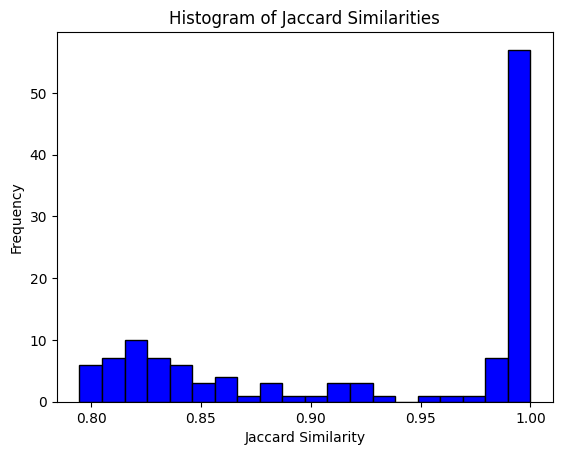

In [31]:
# histogram of jaccard similarities
plt.hist(similar_pairs_df['JaccardSimilarity'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Jaccard Similarities')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
plt.show()

In [32]:
# sort the pairs based on jaccard similarity
sorted_pairs = similar_pairs_df.sort_values(by='JaccardSimilarity')

In [33]:
# select the top 3 lowest
low_similarity_pairs = sorted_pairs.head(3)

In [34]:
# select the top 3 highest
high_similarity_pairs = sorted_pairs.tail(3)

In [35]:
# function print details of pair
def print_pair_details(pair, df):
    index_A, index_B, similarity = pair
    job_A = df[df['index'] == index_A].iloc[0]
    job_B = df[df['index'] == index_B].iloc[0]
    print(f"Job A - Link: {job_A['job_link']}, Description: {job_A['job_summary']}")
    print(f"Job B - Link: {job_B['job_link']}, Description: {job_B['job_summary']}")
    print(f"Jaccard Similarity: {similarity}\n")

In [36]:
# print details of the selected pairs
print("low jaccard similarity pairs:")
for _, row in low_similarity_pairs.iterrows():
    print_pair_details((row['index_A'], row['index_B'], row['JaccardSimilarity']), df)


Low Jaccard Similarity Pairs:
Job A - Link: https://www.linkedin.com/jobs/view/anesthesiology-physician-%24335-hourly-at-doccafe-3734045975, Description: DocCafe has an immediate opening for the following position: Physician - Anesthesiology in Louisville, Kentucky.
This is a full-time position. Make $335/hourly.
DocCafe is the premier physician and physician assistant job board to help you advance your healthcare career.
Register now to apply for this job and for access to 125,000+ other openings.
DocCafe Offers:
Free Physician and Physician Assistant Job Search Easily search, review and apply to jobs that meet your requirements. Plus, set up e-mail alerts for when new jobs are added that meet your search criteria.
Professional Profile Attract employers with a profile page that includes your CV, credentials and other medical professional information.
Confidentiality Decide which information you want to share and when you appear in an employer’s search results.
Career Matching Support 

In [37]:
print("high jaccard similarity pairs:")
for _, row in high_similarity_pairs.iterrows():
    print_pair_details((row['index_A'], row['index_B'], row['JaccardSimilarity']), df)

High Jaccard Similarity Pairs:
Job A - Link: https://www.linkedin.com/jobs/view/store-manager-at-turkey-hill-minit-markets-3647591966, Description: Description
Are you a high energy, passionate retail leader who is looking for the next step in their career? Are you someone who loves to help others and work as part of a team? Do you thrive in fast-paced environments and have previous experience in retail, food service or restaurant management? Do you like discounts on gas and free coffee?
Then you may be the perfect addition to our team!
What We Offer
Competitive Wages
Professional Structured Training program
Monthly bonus potential up to additional Two Dollars and 25 Cents for each hour worked in a month
Work today, get paid tomorrow through our earned wage access program*
Paid Time Off
Medical/Health/Dental Coverage
401K with Company Match
Team Member Discounts
Tuition Reimbursement
Employee Assistance Program
Health Savings Account
Company Spirit Days
And much more!
Managers In Train

In [38]:
similar_pairs_df.describe()

,index_A,index_B,JaccardSimilarity
count,1.230000e+02,1.230000e+02,123.000000
mean,5.804319e+05,6.610262e+05,0.927001
std,3.309510e+05,3.190677e+05,0.080605
min,1.076800e+04,1.076800e+04,0.794721
25%,3.007965e+05,3.930160e+05,0.837143
50%,6.395620e+05,8.189010e+05,0.982154
75%,8.712215e+05,8.707520e+05,1.000000
max,1.297099e+06,1.236224e+06,1.000000


In [64]:
df.shape[0]

12970

In [40]:
similar_pairs_df.shape[0]/df.shape[0]


0.009483423284502699

0.009483423284502699


In [41]:
# pivot table for the heatmap
similar_pairs_df_pivot = pd.pivot_table(similar_pairs_df, values='JaccardSimilarity', index='index_A', columns='index_B')



In [42]:
# NaN values with 0
similar_pairs_df_pivot = similar_pairs_df_pivot.fillna(0)

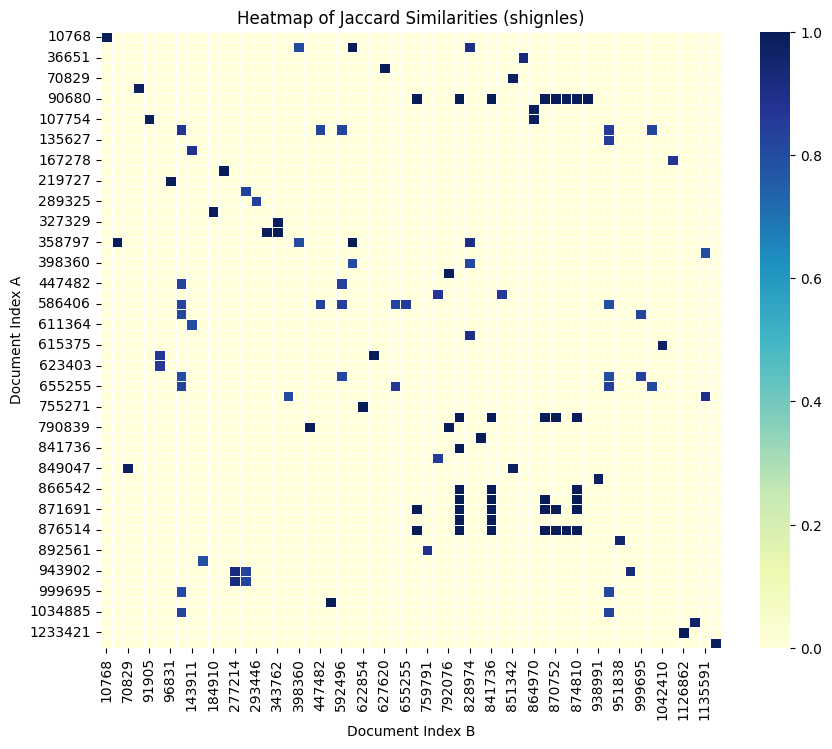

In [65]:
# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similar_pairs_df_pivot, annot=False, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Jaccard Similarities (shignles)')
plt.xlabel('Document Index B')
plt.ylabel('Document Index A')
plt.show()

2.9.	Calculate pair wise Jaccard similarity value on minhash level for demonstration

In [49]:
# jaccard similarity function for mh
def jaccard_similarity_minhash(minhash1, minhash2):
    intersection = sum(1 for x, y in zip(minhash1, minhash2) if x == y)
    return intersection / len(minhash1)

In [50]:
# similar pairs above the threshold
similar_pairs_minhash = []
for (i, j) in candidates:
    minhash_i = df[df['index'] == i]['minhash'].values[0]
    minhash_j = df[df['index'] == j]['minhash'].values[0]
    similarity = jaccard_similarity_minhash(minhash_i, minhash_j)
    if similarity >= threshold:
        similar_pairs_minhash.append((i, j, similarity))



In [51]:
# convert to dataFrame
similar_pairs_minhash_df = pd.DataFrame(similar_pairs_minhash, columns=['index_A', 'index_B', 'JaccardSimilarity'])



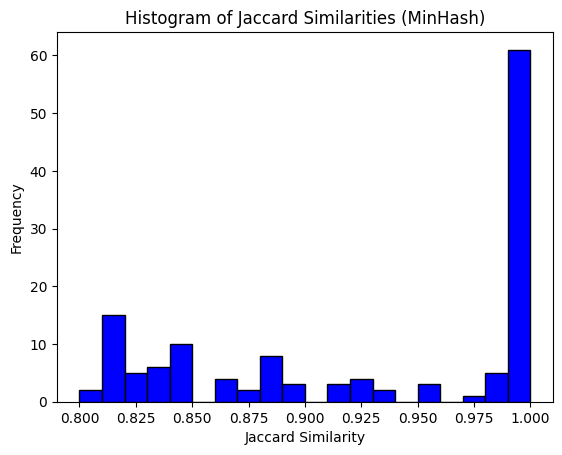

In [52]:
# histogram
plt.hist(similar_pairs_minhash_df['JaccardSimilarity'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Jaccard Similarities (MinHash)')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
plt.show()

In [53]:
#pivot table for the heatmap
similarity_pivot = pd.pivot_table(similar_pairs_minhash_df, values='JaccardSimilarity', index='index_A', columns='index_B')



In [54]:
#NaN values with 0
similarity_pivot = similarity_pivot.fillna(0)

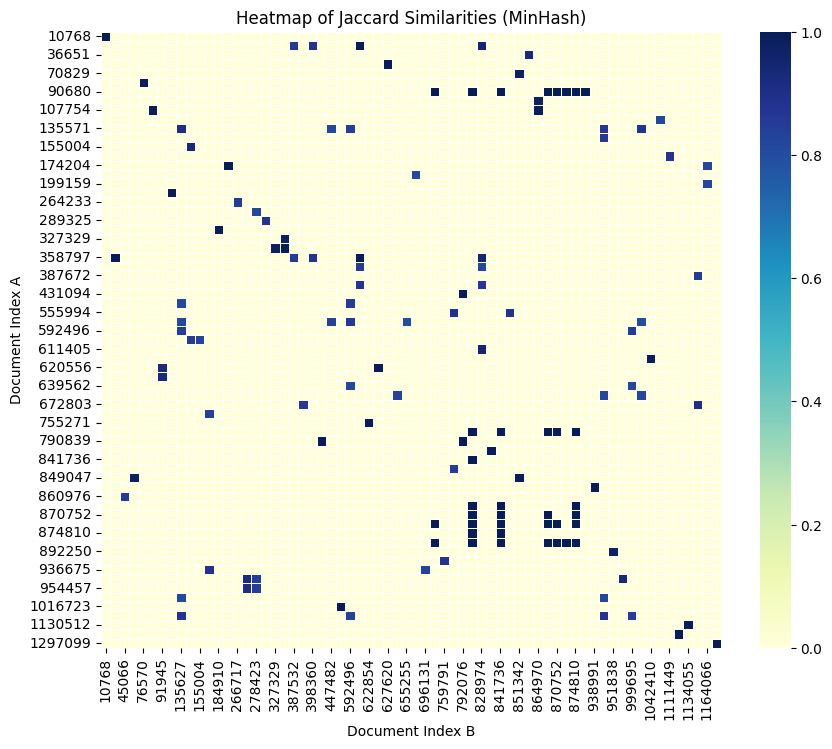

In [55]:
# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_pivot, annot=False, cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Jaccard Similarities (MinHash)')
plt.xlabel('Document Index B')
plt.ylabel('Document Index A')
plt.show()

compare histogram and heatmap

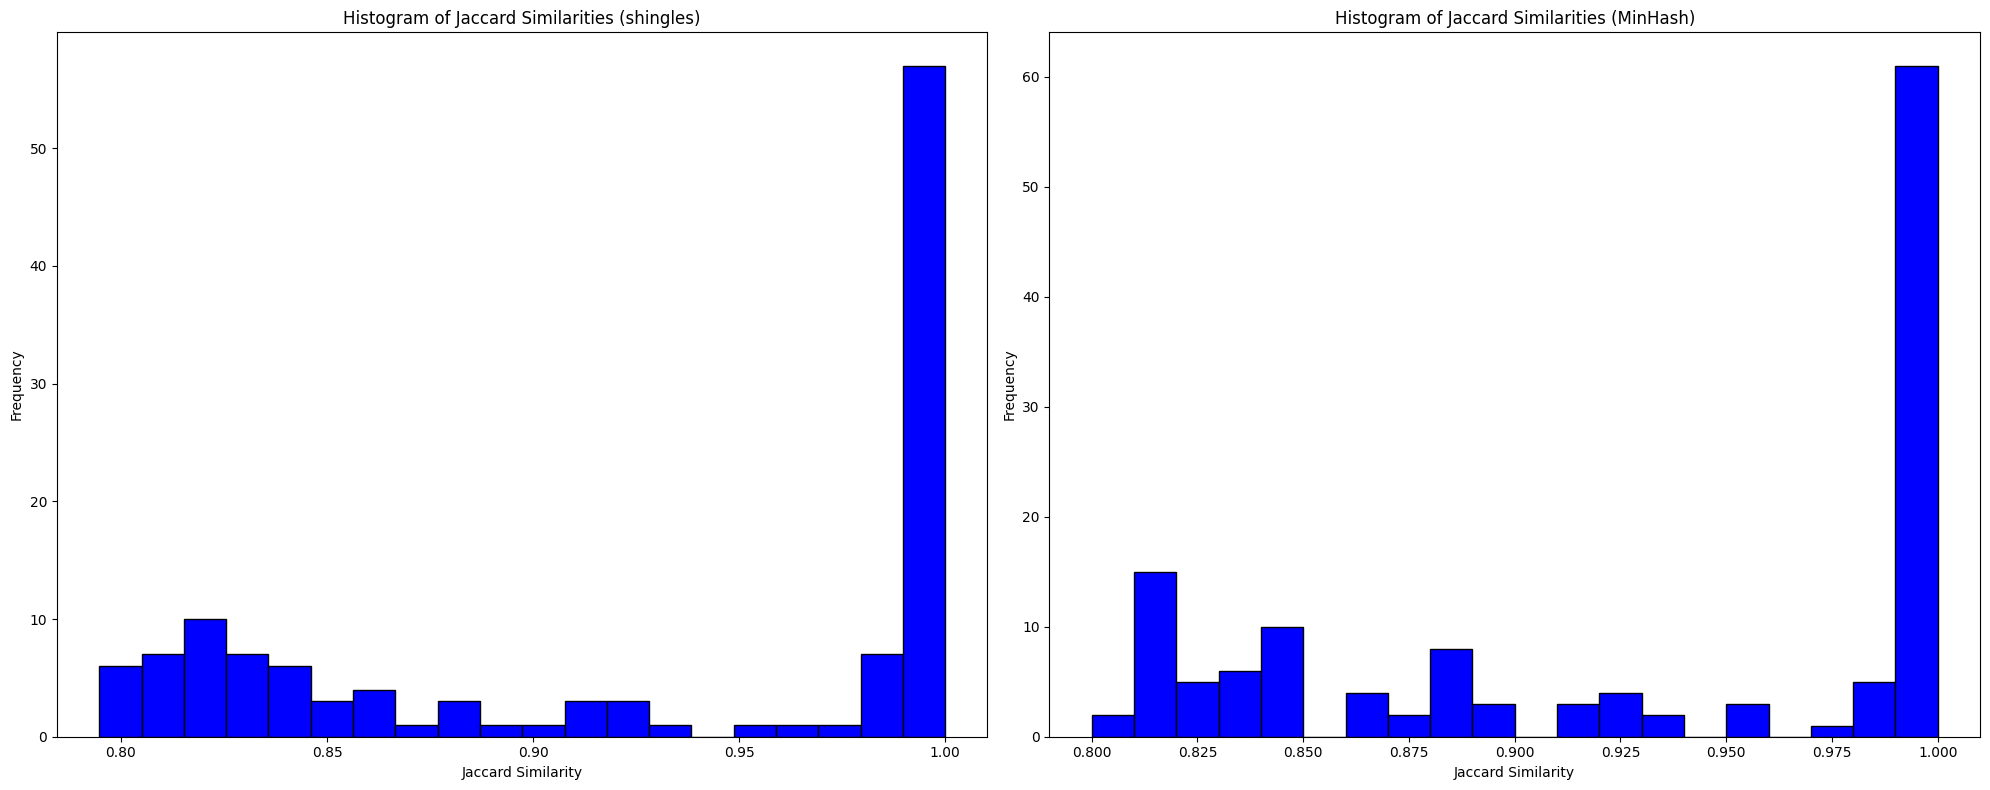

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# histogram of shingle level jaccard similarities
axes[0].hist(similar_pairs_df['JaccardSimilarity'], bins=20, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Jaccard Similarities (shingles)')
axes[0].set_xlabel('Jaccard Similarity')
axes[0].set_ylabel('Frequency')

# histogram of mh level jaccard similarities
axes[1].hist(similar_pairs_minhash_df['JaccardSimilarity'], bins=20, color='blue', edgecolor='black')
axes[1].set_title('Histogram of Jaccard Similarities (MinHash)')
axes[1].set_xlabel('Jaccard Similarity')
axes[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

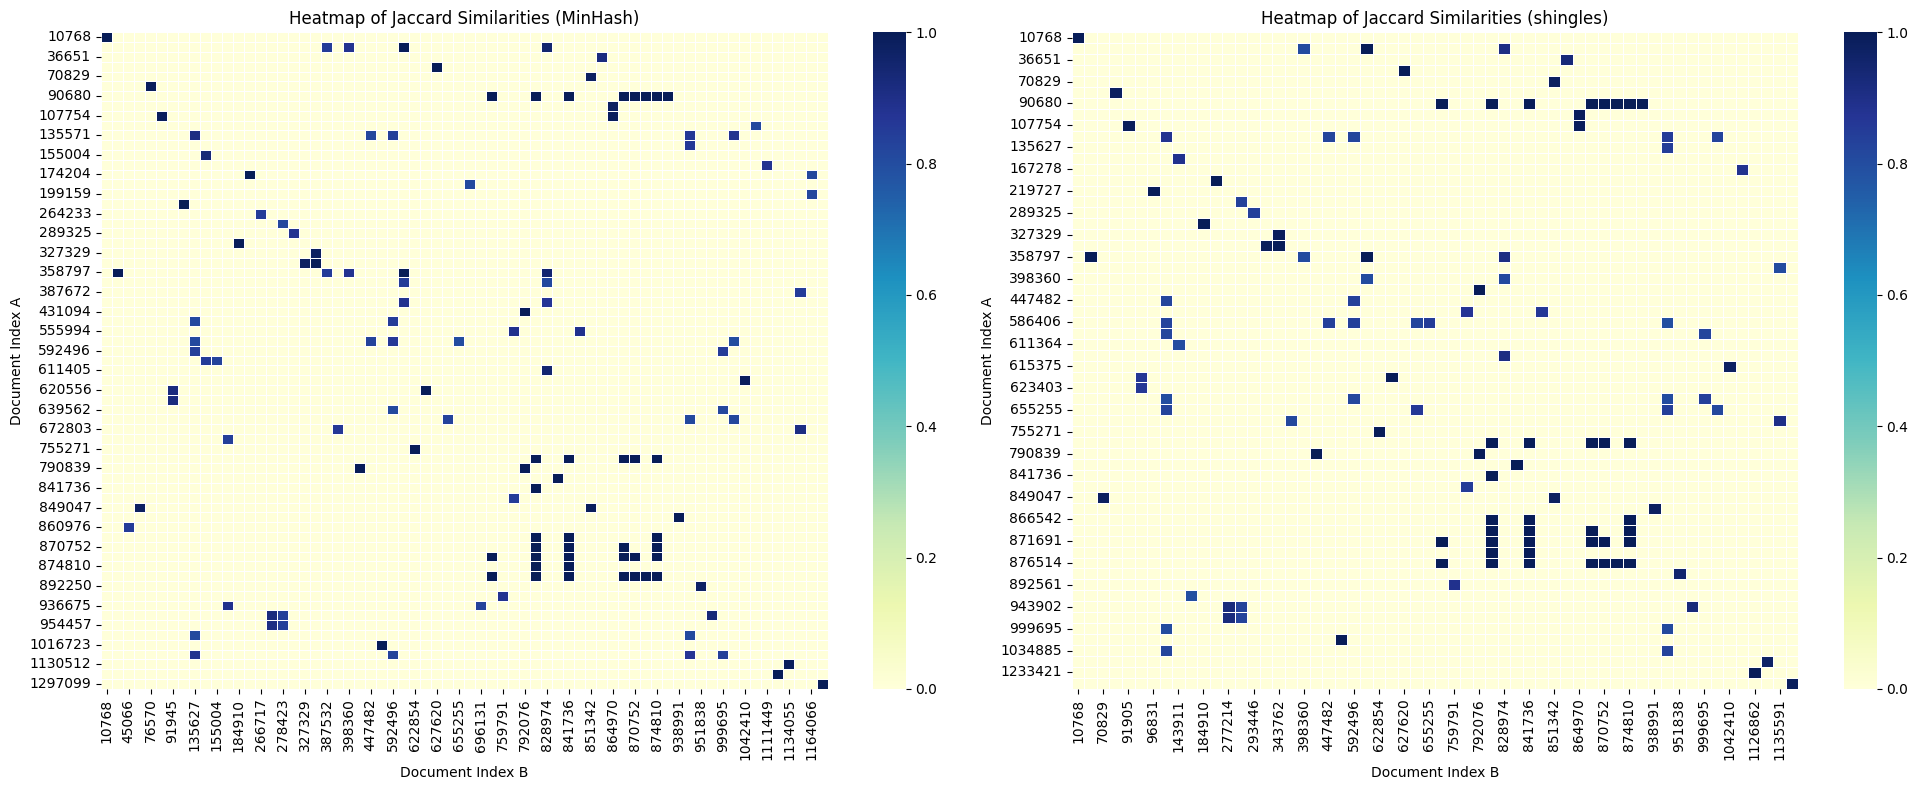

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# heatmap shingle wise
sns.heatmap(similarity_pivot, annot=False, cmap='YlGnBu', linewidths=.5, ax=axes[0])
axes[0].set_title('Heatmap of Jaccard Similarities (MinHash)')
axes[0].set_xlabel('Document Index B')
axes[0].set_ylabel('Document Index A')

# heatmap shingle mh wise
sns.heatmap(similar_pairs_df_pivot, annot=False, cmap='YlGnBu', linewidths=.5, ax=axes[1])
axes[1].set_title('Heatmap of Jaccard Similarities (shingles)')
axes[1].set_xlabel('Document Index B')
axes[1].set_ylabel('Document Index A')

plt.tight_layout()
plt.show()


band level

In [72]:
# band wise jaccard similarity
def jaccard_similarity(band1, band2):
    return len(set(band1).intersection(set(band2))) / len(set(band1).union(set(band2)))


In [74]:
# similar pairs above the threshold
similar_pairs_bands = []
for (i, j) in candidates:
    bands_i = df[df['index'] == i]['bands'].values[0]
    bands_j = df[df['index'] == j]['bands'].values[0]

    # Ensure bands_i and bands_j are iterable
    if not isinstance(bands_i, (list, set)):
        bands_i = [bands_i]
    if not isinstance(bands_j, (list, set)):
        bands_j = [bands_j]

    similarity = jaccard_similarity(bands_i, bands_j)
    if similarity >= threshold:
        similar_pairs_bands.append((i, j, similarity))

In [75]:
# convert to dataFrame
similar_pairs_bands_df = pd.DataFrame(similar_pairs_bands, columns=['index_A', 'index_B', 'JaccardSimilarity'])


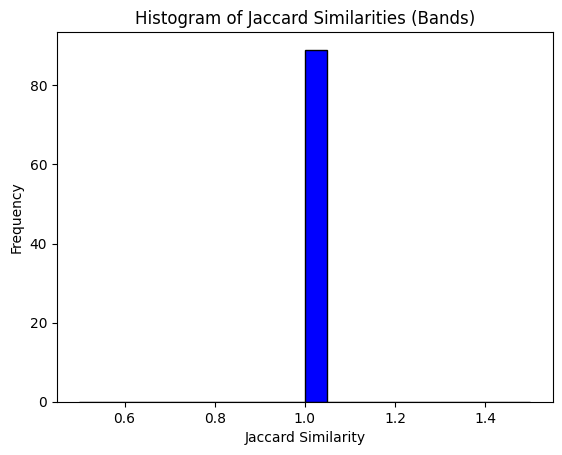

In [76]:
# histogram
plt.hist(similar_pairs_bands_df['JaccardSimilarity'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Jaccard Similarities (Bands)')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
plt.show()

In [77]:
# sort the pairs based on jaccard similarity
sorted_pairs_bands = similar_pairs_bands_df.sort_values(by='JaccardSimilarity')


In [78]:
# top 3 lowest
low_similarity_pairs_bands = sorted_pairs_bands.head(3)


In [79]:
# top 3 highest
high_similarity_pairs_bands = sorted_pairs_bands.tail(3)

In [80]:
# print the details of a pair
def print_pair_details(pair, df):
    index_A, index_B, similarity = pair
    job_A = df[df['index'] == index_A].iloc[0]
    job_B = df[df['index'] == index_B].iloc[0]
    print(f"Job A - Link: {job_A['job_link']}, Description: {job_A['job_summary']}")
    print(f"Job B - Link: {job_B['job_link']}, Description: {job_B['job_summary']}")
    print(f"Jaccard Similarity: {similarity}\n")

In [81]:
# print selected pairs
print("Low Jaccard Similarity Pairs (Bands):")
for _, row in low_similarity_pairs_bands.iterrows():
    print_pair_details((row['index_A'], row['index_B'], row['JaccardSimilarity']), df)


Low Jaccard Similarity Pairs (Bands):
Job A - Link: https://www.linkedin.com/jobs/view/residency-bcba-at-action-behavior-centers-aba-therapy-for-autism-3789913416, Description: Premier ABA Provider for Children with Autism
*We are a Responsive Employer - we will be in touch with you within 24 hours of applying*
What is our Residency BCBA position?
Option 1: An 18 month paid relocation adventure to Houston, Tucson, San Antonio, Dallas or Phoenix by ABC PLUS a higher wage!
Option 2: A permanent relocation to Texas, Arizona, or Minnesota with a comprehensive relocation reimbursement package.
This position is built for an excellent BCBA that is either newly certified or wanting to grow in their career.
Flexible Onsite Schedules with 5 different schedule options
$30,000 Long-Term Incentive Plans over 3 years eligible for promotions to ACD and above
You would gain a wealth of clinical skills, leadership strategies, and more by working with our established markets to bring into our new market

In [82]:
print("High Jaccard Similarity Pairs (Bands):")
for _, row in high_similarity_pairs_bands.iterrows():
    print_pair_details((row['index_A'], row['index_B'], row['JaccardSimilarity']), df)


High Jaccard Similarity Pairs (Bands):
Job A - Link: https://www.linkedin.com/jobs/view/department-supervisor-at-the-home-depot-3633814507, Description: Job Description
Department Supervisors lead, train, coach and develop associates in each department to ensure customers receive excellent service and can easily find the merchandise they need. In addition, they provide valuable input into operational and merchandising decisions to the Store Management Team and Operations Team. Department Supervisors have strong product and operational knowledge. Specific store departments may include Building Materials, Decor, Electrical, Flooring, Gardening, Hardware, Kitchen & Bath, Lumber, Millwork, Paint, Plumbing, Pro Account Sales, Tool Rental, Front End, Freight, Receiving, Associate Support, Special Services, and Merchandising Execution or a combination of multiple departments depending on store structure.
Show more
Show less
Job B - Link: https://www.linkedin.com/jobs/view/department-superviso

In [83]:
similar_pairs_bands_df.describe()


,index_A,index_B,JaccardSimilarity
count,8.900000e+01,8.900000e+01,89.0
mean,5.776368e+05,6.562482e+05,1.0
std,3.601580e+05,2.979132e+05,0.0
min,1.076800e+04,1.076800e+04,1.0
25%,2.000850e+05,3.754640e+05,1.0
50%,7.582020e+05,8.189010e+05,1.0
75%,8.716910e+05,8.707520e+05,1.0
max,1.297099e+06,1.236224e+06,1.0


check stats

In [71]:
count_of_candidates = len(candidates)
print(count_of_candidates)

239


In [89]:
df

,job_link,job_summary,index,processed_text,shingles,minhash,bands
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",1832693374
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",4161995593
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",2705918667
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",4094176497
616910,https://www.linkedin.com/jobs/view/manager-mai...,"Company Description\nCore-Mark, a Performance ...",616910,compani descript coremark perform food group c...,"[d equal em, mpressor i, edul abl w, local st...","[0, 1, 1, 0, 0, 1, 4, 6, 0, 0, 1, 3, 2, 8, 12,...",618796170
...,...,...,...,...,...,...,...
339093,https://www.linkedin.com/jobs/view/clinical-nu...,Description\nIntroduction\nDo you currently ha...,339093,descript introduct current opportun make real ...,"[atter expe, tun travel, local sta, n clinic ...","[2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 5, 0, 0, ...",3065204329
339093,https://www.linkedin.com/jobs/view/clinical-nu...,Description\nIntroduction\nDo you currently ha...,339093,descript introduct current opportun make real ...,"[atter expe, tun travel, local sta, n clinic ...","[2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 5, 0, 0, ...",1808235022
339093,https://www.linkedin.com/jobs/view/clinical-nu...,Description\nIntroduction\nDo you currently ha...,339093,descript introduct current opportun make real ...,"[atter expe, tun travel, local sta, n clinic ...","[2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 5, 0, 0, ...",2606220332
339093,https://www.linkedin.com/jobs/view/clinical-nu...,Description\nIntroduction\nDo you currently ha...,339093,descript introduct current opportun make real ...,"[atter expe, tun travel, local sta, n clinic ...","[2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 5, 0, 0, ...",709395444


In [56]:
df.shape[0]

12970

In [90]:
similar_pairs_df

,index_A,index_B,JaccardSimilarity
0,219727,96831,1.000000
1,431094,792076,1.000000
2,871691,758202,1.000000
3,866542,874810,1.000000
4,155004,143911,0.886825
...,...,...,...
118,90680,876514,1.000000
119,672803,387672,0.815403
120,1034885,948701,0.828239
121,758202,874810,1.000000


In [57]:
similar_pairs_df.shape[0]

123

In [69]:
similar_pairs_df.shape[0]/df.shape[0]


0.009483423284502699

In [91]:
similar_pairs_minhash_df

,index_A,index_B,JaccardSimilarity
0,219727,96831,1.00
1,431094,792076,1.00
2,871691,758202,1.00
3,866542,874810,1.00
4,155004,143911,0.93
...,...,...,...
129,90680,876514,1.00
130,672803,387672,0.86
131,1034885,948701,0.87
132,758202,874810,1.00


In [58]:
similar_pairs_minhash_df.shape[0]

134

In [59]:
similar_pairs_minhash_df.shape[0]/df.shape[0]


0.010331534309946029

In [92]:
similar_pairs_bands_df

,index_A,index_B,JaccardSimilarity
0,219727,96831,1.0
1,431094,792076,1.0
2,871691,758202,1.0
3,866542,874810,1.0
4,90680,841736,1.0
...,...,...,...
84,90680,876514,1.0
85,1034885,447482,1.0
86,758202,874810,1.0
87,892561,428937,1.0


In [84]:
similar_pairs_bands_df.shape[0]

89

In [85]:
similar_pairs_bands_df.shape[0]/df.shape[0]

0.006861989205859676

possible false positive pairs from shingle to minhash

In [60]:
similar_pairs_minhash_df.shape[0]-similar_pairs_df.shape[0]

11

potentially reduce false positives on band and buket step

In [87]:
similar_pairs_bands_df.shape[0]-similar_pairs_df.shape[0]

-34

In [93]:
def get_pair_details(pair, df):
    if pair is None:
        return "No example found"
    index_A, index_B = pair
    job_A = df[df['index'] == index_A].iloc[0]
    job_B = df[df['index'] == index_B].iloc[0]
    details = (
        f"Job A - Link: {job_A['job_link']}, Description: {job_A['job_summary']}\n"
        f"Job B - Link: {job_B['job_link']}, Description: {job_B['job_summary']}\n"
    )
    return details

In [94]:
# dataFrame pairs to sets comparison
similar_pairs_set = set(zip(similar_pairs_df['index_A'], similar_pairs_df['index_B']))
similar_pairs_bands_set = set(zip(similar_pairs_bands_df['index_A'], similar_pairs_bands_df['index_B']))
similar_pairs_minhash_set = set(zip(similar_pairs_minhash_df['index_A'], similar_pairs_minhash_df['index_B']))

# pairs in similar_pairs_df but not in similar_pairs_bands_df
shingle_not_in_bands = similar_pairs_set - similar_pairs_bands_set

# pairs that in similar_pairs_minhash_df but not in similar_pairs_df
minhash_not_in_shingle = similar_pairs_minhash_set - similar_pairs_set

Example in similar_pairs_df but not in similar_pairs_bands_df:
Job A - Link: https://www.linkedin.com/jobs/view/clinical-psychologist-travel-at-mrg-exams-3803825977, Description: MRG Exams Providing Disability Assessments Nationwide To Serve Our Veterans Help Military Families – Achieve Work-Life Balance – Make a Difference Founded in 1998, MRG is a provider of Independent Medical Exams for Worker’s Compensation, Disability, and the Veterans Administration. Find out more at MRGExams.com. Job Overview Are you a Licensed Psychologist with a PsyD, or Ph.D. looking to take on an assessment role? Are you interested in performing Independent Medical Assessments vs. traditional patient care? Would you find it rewarding to serve the Veteran community? Would you enjoy being able to review medical records and complete assessment questionnaires to help Veterans? Description We are looking for a Licensed Psychologist to perform medical assessments on United States Veterans as part of the VA’s disa

In [95]:
# two examples from each group
examples_shingle_not_in_bands = list(shingle_not_in_bands)[:2] if len(shingle_not_in_bands) >= 2 else list(shingle_not_in_bands)
examples_minhash_not_in_shingle = list(minhash_not_in_shingle)[:2] if len(minhash_not_in_shingle) >= 2 else list(minhash_not_in_shingle)

# print the details of each example
details_shingle_not_in_bands = [get_pair_details(pair, df) for pair in examples_shingle_not_in_bands]
details_minhash_not_in_shingle = [get_pair_details(pair, df) for pair in examples_minhash_not_in_shingle]

print("Examples in similar_pairs_df (shingle level) but not in similar_pairs_bands_df (bands level):")
for detail in details_shingle_not_in_bands:
    print(detail)

print("Examples in similar_pairs_minhash_df (MinHash level) but not in similar_pairs_df (shingle level):")
for detail in details_minhash_not_in_shingle:
    print(detail)

Examples in similar_pairs_df (shingle level) but not in similar_pairs_bands_df (bands level):
Job A - Link: https://www.linkedin.com/jobs/view/clinical-psychologist-travel-at-mrg-exams-3803825977, Description: MRG Exams Providing Disability Assessments Nationwide To Serve Our Veterans Help Military Families – Achieve Work-Life Balance – Make a Difference Founded in 1998, MRG is a provider of Independent Medical Exams for Worker’s Compensation, Disability, and the Veterans Administration. Find out more at MRGExams.com. Job Overview Are you a Licensed Psychologist with a PsyD, or Ph.D. looking to take on an assessment role? Are you interested in performing Independent Medical Assessments vs. traditional patient care? Would you find it rewarding to serve the Veteran community? Would you enjoy being able to review medical records and complete assessment questionnaires to help Veterans? Description We are looking for a Licensed Psychologist to perform medical assessments on United States Ve

In [61]:
# end time and total runtime
end_time = time.time()
total_time = end_time - start_time

In [62]:
# time to a readable format
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total runtime: {:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

Total runtime: 00:03:54.69
